#Multilingual Hate Speech Detection using Transformers
This notebook implements a multilingual hate speech detection system using transformers. The goal is to classify text as hateful or non-hateful across hindi, english and hinglish(mix) and compare the performance of two multilingual models: mBERT and XLM-RoBERTa.

Installing required libraries for training and evaluation:

In [ ]:
!pip install -q transformers datasets scikit-learn torch accelerate


In [ ]:
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)


Loading the dataset and retain only relevant columns:

In [ ]:
df = pd.read_csv("combined_hate_speech_dataset.csv")

df = df[['text', 'hate_label', 'profanity_score', 'language']]
df = df.dropna()

df.head()

df['hate_label'] = df['hate_label'].astype(int)



Spliting the dataset for training and testing:

In [ ]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['hate_label'],
    random_state=42
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))


Train size: 23640
Test size: 5910


Performing Text Tokanization: Converting raw text into token that the model can understand using padding(sequences of token in the batch have the same length) and trucation(reduce length if beyond the limit).

In [ ]:
def tokenize_data(tokenizer, texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=64
    )


Create a custom PyTorch Dataset to efficiently pass tokenized inputs and labels to the model.

In [ ]:
class HateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


Evaluation:

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary'
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


Model Training: Used for both mBERT and XLM-RoBERTa

In [ ]:
def train_model(model_name, train_df, test_df):
    print(f"\nTraining {model_name}...\n")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    train_enc = tokenize_data(tokenizer, train_df['text'].tolist())
    test_enc = tokenize_data(tokenizer, test_df['text'].tolist())

    train_dataset = HateDataset(train_enc, train_df['hate_label'].tolist())
    test_dataset = HateDataset(test_enc, test_df['hate_label'].tolist())

    args = TrainingArguments(
        output_dir=f"./results_{model_name}",
        do_eval=True,
        save_strategy="no",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        learning_rate=2e-5,
        logging_steps=50,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()
    metrics = trainer.evaluate()

    return trainer, tokenizer, metrics


Training mBERT Model: Fine-tune the multilingual BERT (mBERT) model on the training dataset and evaluate

In [ ]:
mbert_trainer, mbert_tokenizer, mbert_metrics = train_model(
    "bert-base-multilingual-cased",
    train_df,
    test_df
)

mbert_metrics



Training bert-base-multilingual-cased...



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.677700
100,0.649500
150,0.626100
200,0.604500
250,0.602000
300,0.631400
350,0.561000
400,0.590900
450,0.552500
500,0.572900


{'eval_loss': 0.5224353075027466,
 'eval_accuracy': 0.7225042301184433,
 'eval_precision': 0.7160735236605397,
 'eval_recall': 0.6670309653916211,
 'eval_f1': 0.6906827612221803,
 'eval_runtime': 22.4641,
 'eval_samples_per_second': 263.086,
 'eval_steps_per_second': 16.471,
 'epoch': 1.0}

Training XLM-RoBERTa Model: Fine-tune the XLM-RoBERTa model on the training dataset and evaluate

In [ ]:
xlmr_trainer, xlmr_tokenizer, xlmr_metrics = train_model(
    "xlm-roberta-base",
    train_df,
    test_df
)

xlmr_metrics



Training xlm-roberta-base...



tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.698400
100,0.676100
150,0.646500
200,0.640700
250,0.628400
300,0.643000
350,0.597100
400,0.618900
450,0.574000
500,0.588200


{'eval_loss': 0.5476357340812683,
 'eval_accuracy': 0.7253807106598985,
 'eval_precision': 0.7323943661971831,
 'eval_recall': 0.64408014571949,
 'eval_f1': 0.6854041480907153,
 'eval_runtime': 21.1466,
 'eval_samples_per_second': 279.477,
 'eval_steps_per_second': 17.497,
 'epoch': 1.0}

Model Performance Comparision

In [ ]:
comparison = pd.DataFrame({
    "Model": ["mBERT", "XLM-RoBERTa"],
    "Accuracy": [mbert_metrics['eval_accuracy'], xlmr_metrics['eval_accuracy']],
    "F1 Score": [mbert_metrics['eval_f1'], xlmr_metrics['eval_f1']]
})

comparison


,Model,Accuracy,F1 Score
0,mBERT,0.722504,0.690683
1,XLM-RoBERTa,0.725381,0.685404


Language-wise Error Analysis: Analyzing how model performance varies across languages

In [ ]:
def language_wise_errors(trainer, tokenizer, df):
    enc = tokenize_data(tokenizer, df['text'].tolist())
    dataset = HateDataset(enc, df['hate_label'].tolist())

    preds = trainer.predict(dataset)
    y_pred = np.argmax(preds.predictions, axis=1)

    df_temp = df.copy()
    df_temp['predicted'] = y_pred
    df_temp['error'] = df_temp['hate_label'] != df_temp['predicted']

    return df_temp.groupby('language')['error'].mean().sort_values(ascending=False)


In [ ]:
language_wise_errors(mbert_trainer, mbert_tokenizer, test_df)


,error
language,
hindi,0.388974
hinglish,0.291533
english,0.200795


In [ ]:
language_wise_errors(xlmr_trainer, xlmr_tokenizer, test_df)


,error
language,
hindi,0.383359
hinglish,0.300107
english,0.196156


Confusion Matrix Analysis: Helps understanding False Positives and False Negatives

In [ ]:
def show_confusion(trainer, tokenizer, df):
    enc = tokenize_data(tokenizer, df['text'].tolist())
    dataset = HateDataset(enc, df['hate_label'].tolist())

    preds = trainer.predict(dataset)
    y_pred = np.argmax(preds.predictions, axis=1)

    return confusion_matrix(df['hate_label'], y_pred)

show_confusion(xlmr_trainer, xlmr_tokenizer, test_df)


array([[2519,  646],
       [ 977, 1768]])

Importing libraries used for Visulaizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


Model Performance Comparison Bar Chart

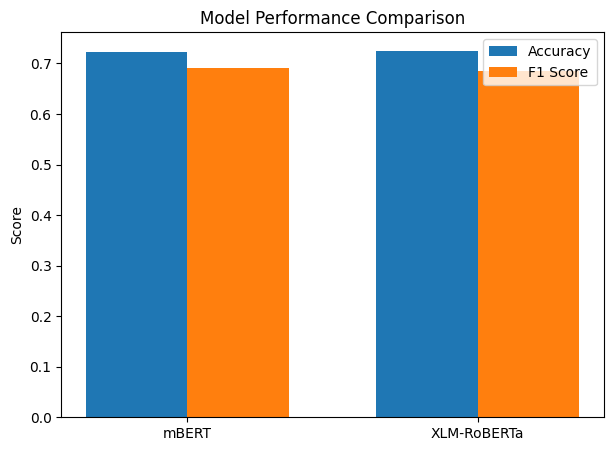

In [ ]:
models = ['mBERT', 'XLM-RoBERTa']
accuracy = [mbert_metrics['eval_accuracy'], xlmr_metrics['eval_accuracy']]
f1 = [mbert_metrics['eval_f1'], xlmr_metrics['eval_f1']]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, accuracy, width, label='Accuracy')
plt.bar(x + width/2, f1, width, label='F1 Score')

plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()


Detailed Metrics Visualization (Precision vs Recall)

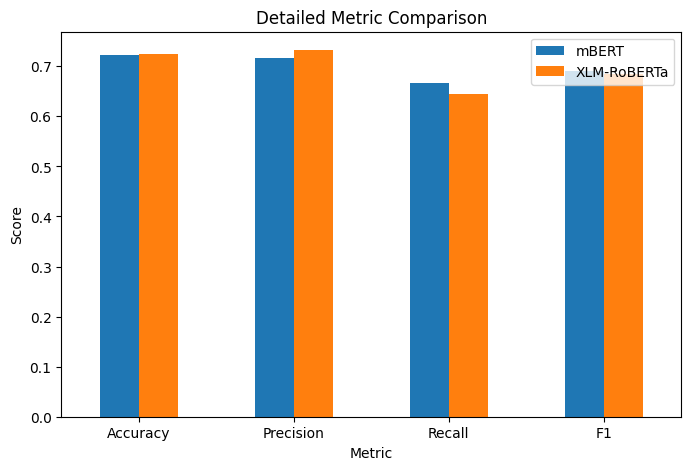

In [ ]:
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'mBERT': [
        mbert_metrics['eval_accuracy'],
        mbert_metrics['eval_precision'],
        mbert_metrics['eval_recall'],
        mbert_metrics['eval_f1']
    ],
    'XLM-RoBERTa': [
        xlmr_metrics['eval_accuracy'],
        xlmr_metrics['eval_precision'],
        xlmr_metrics['eval_recall'],
        xlmr_metrics['eval_f1']
    ]
})

metrics_df.set_index('Metric').plot(
    kind='bar',
    figsize=(8,5)
)

plt.title('Detailed Metric Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


Language-Wise Error Rate Visualization with Error Caluculation

In [ ]:
def get_language_errors(trainer, tokenizer, df):
    enc = tokenize_data(tokenizer, df['text'].tolist())
    dataset = HateDataset(enc, df['hate_label'].tolist())

    preds = trainer.predict(dataset)
    y_pred = np.argmax(preds.predictions, axis=1)

    temp = df.copy()
    temp['pred'] = y_pred
    temp['error'] = temp['pred'] != temp['hate_label']

    return temp.groupby('language')['error'].mean().sort_values(ascending=False)


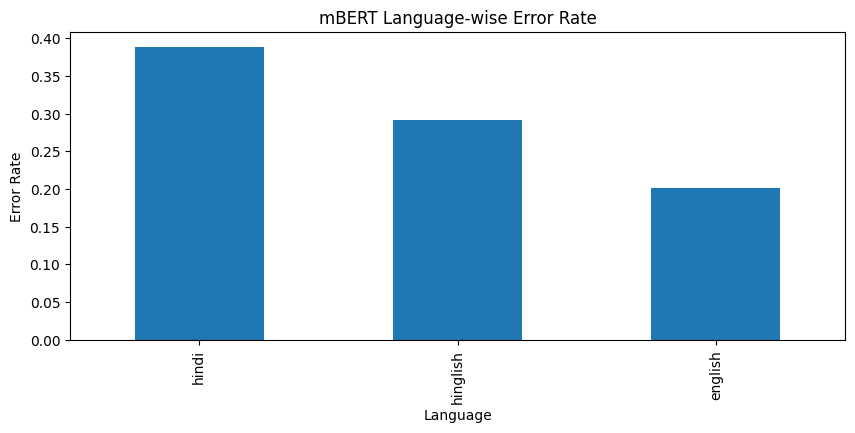

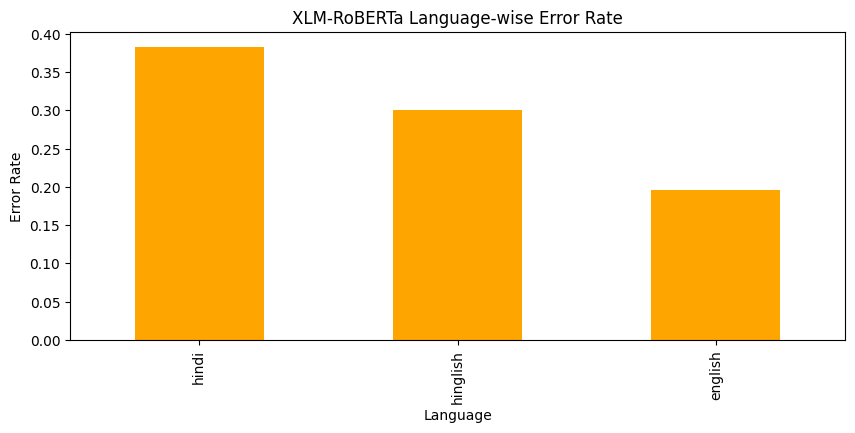

In [ ]:
mbert_lang_error = get_language_errors(
    mbert_trainer, mbert_tokenizer, test_df
)

xlmr_lang_error = get_language_errors(
    xlmr_trainer, xlmr_tokenizer, test_df
)

plt.figure(figsize=(10,4))
mbert_lang_error.plot(kind='bar')
plt.title('mBERT Language-wise Error Rate')
plt.ylabel('Error Rate')
plt.xlabel('Language')
plt.show()

plt.figure(figsize=(10,4))
xlmr_lang_error.plot(kind='bar', color='orange')
plt.title('XLM-RoBERTa Language-wise Error Rate')
plt.ylabel('Error Rate')
plt.xlabel('Language')
plt.show()
